In [821]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
import math
import matplotlib.colors as mcolors


class Point:
    """
    Create a point in space."""
    def __init__(self,x,y, identifier=None, mass=1.0,vx=0,vy=0, acc_x=0, acc_y=0, color=None):
        """
        Each point will have:
        mass (default 1.0),
        vx = velocity x_component (default = 0),
        vy = velocity y_component (default = 0),
        acc_x = acceleration x_component (default = 0),
        acc_y = acceleration y_component (default = 0)"""
        self.x = x
        self.y = y
        self.mass = mass
        self.vx = vx
        self.vy = vy
        self.acc_x = acc_x
        self.acc_y = acc_y
        if identifier == None:
            self.identifier = np.random.randint(20,1000)
        else:    
            self.identifier = identifier
        self.color = color

    def update_position(self, quadtree,dt):
        """Updates the position of the point based 
        on the Barnes-Hut algorithm
        quadtree = Quadtree object,
        dt = unit time
        """
        
        # Calculate the net force on the point
        force_x, force_y = quadtree.calculate_force(self)
        # Update the position
        self.vx += force_x / self.mass
        self.vy += force_y / self.mass
        self.x += self.vx*dt
        self.y += self.vy*dt
    

    def find_stable_orbital_velocity(self, central_point, g_const):
        """
        Find the stable orbital velocity for the point
        ***
        central_point must be a point object!
        ***
        """
        G = g_const
        dx = -(self.x-central_point.x)
        dy = -(self.y-central_point.y)
        
        r = math.sqrt(dx ** 2 + dy ** 2) # distance between the point and central mass
        velocity = math.sqrt((G * central_point.mass) / r)
        angle = math.atan2(dy,dx)
        self.vx = velocity * math.cos(angle)
        self.vy = velocity * math.sin(angle)
        
        
        
class Rectangle:
    def __init__(self,x,y,w,h):
        """
        x = center of the Rectangle
        y = center of the Rectangle
        w = width of the rectangle
        h = height of the rectangle
        """
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.west_edge, self.east_edge = x - w/2, x + w/2
        self.north_edge, self.south_edge = y + h/2, y - h/2

    def contains(self,point):
        return (point.x >= self.west_edge and point.x <= self.east_edge and
        point.y <= self.north_edge and point.y >= self.south_edge)

    def intersects(self,other):
        """Does the other Rectangle object intersect with this one?"""
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

    def show(self, axis,color='red'):
        x1, y1 = self.west_edge,self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        axis.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c=color, lw=1)
        
        

class Quadtree:

    def __init__(self,boundary, G,theta_, n = 1):
        """
        Creates a Quadtree:
        boundary: Rectangle instance
        n = capacity
            choosing n = 1, i.e. if particle number crosses 1 than sub-divide
        G = gravitational constant
        theta_ = barnes hut algo theta (default value = 1)
        """
        self.boundary = boundary

        # choosing capacity(n) = 1, i.e. if particle number crosses 1 than sub-divide
        # When do i choose that i need to sub-divide
        self.capacity = n

        # Keep track of points:
        self.points = []
        self.quads = [None, None, None, None]
        self.divided = False
        self.mass = 0.0
        self.G = G
        self.theta_ = theta_
        self.center_of_mass_x = 0.0
        self.center_of_mass_y = 0.0

        
    def create_quadtree(self):
        """
        Returns a new quadtree"""
        return Quadtree(self.boundary,self.G,self.theta_,n=self.capacity)
    
    def subdivide(self):
        """
        Subdivides the region into four parts
               1  |  2
             ____ |____
                  |
               3  |  4
               
               quad[0] = 1st quadrant (north west)
               quad[1] = 2nd quadrant (north east)
               quad[2] = 3rd quadrant (south west)
               quad[3] = 4th quadrant (south east)
        """
        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.w/2
        h = self.boundary.h/2

        ne = Rectangle(x + w/2, y + h/2, w, h)
        self.quads[1] = Quadtree(ne, G= self.G, theta_=self.theta_, n=self.capacity)
        nw = Rectangle(x - w/2, y + h/2, w, h)
        self.quads[0] = Quadtree(nw, G= self.G, theta_=self.theta_, n=self.capacity)
        se = Rectangle(x + w/2, y - h/2, w, h)
        self.quads[3] = Quadtree(se, G= self.G, theta_=self.theta_, n=self.capacity)
        sw = Rectangle(x - w/2, y - h/2, w, h)
        self.quads[2] = Quadtree(sw, G= self.G, theta_=self.theta_, n=self.capacity)

        self.divided = True
        
        # Check if existing points contain in children:
        for point in self.points:
            for quad in self.quads:
                quad.insert(point)
                

    def limit_reached(self):
        """
        Checks the recursive limit and returns Boolean value
        
        Returns: False (if limit not reached)
        Returns: True (if limit reached (stop adding points))
        """
        threshold = 0.1
        
        if self.boundary.w < threshold:
            return True
        
        return False
        
    def insert(self, point):
        """
        Insert a point in the quadtree.
        
        Updates the mass and center of mass for each of the """
        if self.divided:
            for quad in self.quads:
                if quad.insert(point):
                    self.points.append(point)
                    self.mass = sum([p.mass for p in self.points])
                    self.center_of_mass_x = sum([p.mass*p.x for p in self.points])
                    self.center_of_mass_y = sum([p.mass*p.y for p in self.points])
                    return True

        # Check if the point is in Boundary
        if self.boundary.contains(point):

            if len(self.points) < self.capacity and not self.limit_reached():
                self.points.append(point)
                self.mass = point.mass
                self.center_of_mass_x = point.x*point.mass
                self.center_of_mass_y = point.y*point.mass
                return True

            self.points.append(point)
            self.mass = sum([p.mass for p in self.points])
            self.center_of_mass_x = sum([p.mass*p.x for p in self.points])
            self.center_of_mass_y = sum([p.mass*p.y for p in self.points])

            if not self.divided and not self.limit_reached():
                self.subdivide()
                for quad in self.quads:
                    if len(quad.points) == 0:
                        quad.insert(point)
                        return True
        else:
            return False

        
    def center_of_mass(self):
        """
        Returns (X, Y) for COM
        """
        return self.center_of_mass_x/self.mass, self.center_of_mass_y/self.mass
    
    def calculate_force(self, point):
        if self.mass == 0 :
            #print("self.mass = 0")
            return 0,0
        if not self.divided:
            #print("Not divided")
            #print("Using point force calculations:")
            return self._calculate_force_on_point(point)
        else:
            #print(f"It is divided.")
            force_x, force_y = 0,0
            for quad in self.quads:
                #print(f"\nInspecting quad with {quad.boundary.x,quad.boundary.y} center")
                if len(quad.points) != 0:
                    if quad._should_use_approximation(point):
                        #print("Using approximation")
                        fx,fy = quad._calculate_force_on_point_approximation(point)
                        force_x += fx
                        force_y += fy
                    else:
                        #print("Not using approximation")
                        fx, fy = quad.calculate_force(point)
                        force_x += fx
                        force_y += fy
            #print(f"Force = {force_x, force_y}")
            return force_x,force_y

    def _calculate_force_on_point(self, point):
        """Calculates the force on the point due to all other points in the quadtree"""
        #print("Used point force calculation")
        force_x, force_y = 0, 0
        for other_point in self.points:
            if other_point != point:
                dx = other_point.x - point.x
                dy = other_point.y - point.y
                r = (dx ** 2 + dy ** 2) ** 0.5
                if r == 0:
                    continue
                force = self.G * point.mass * other_point.mass / (r ** 2)
                force_x += force * dx / r
                force_y += force * dy / r
        #print(f"force from using no approximation = {force_x,force_y}")
        return force_x, force_y
    
    def _calculate_force_on_point_approximation(self, point):
        """Calculates the force on the point due to the center of mass of the quadtree"""
        com_x,com_y = self.center_of_mass()
        #print(f"used approximation function: \n center of mass = {com_x,com_y}")
        dx = com_x - point.x
        dy = com_y - point.y
        r = (dx ** 2 + dy ** 2) ** 0.5
        if r == 0:
            return 0, 0
        force = self.G * point.mass * self.mass / (r ** 2)
        #print(f"Force from approximation: {force*dx/r,force*dy/r}")
        return force * dx / r, force * dy / r
    
    def _should_use_approximation(self, point):
        com_x, com_y = self.center_of_mass()
        """Determines whether to use the approximation or not"""
        r = ((point.x - com_x)**2 + (point.y - com_y)**2)**0.5
        if r ==0 or len(self.points)==0:
            return False
        #print(f"self.boundary.w = {self.boundary.w} and self.theta = {self.theta_} \n ratio = {self.boundary.w/r}")
        return self.boundary.w / r < self.theta_


    def clear(self):
        """
        Clears the quadtree by resetting all points and sub-quadrants
        """
        self.points = []
        self.mass = 0.0
        self.center_of_mass_x = 0
        self.center_of_mass_y = 0
        self.divided = False
        self.quads = [None, None, None, None]
        
    def show(self, axis=None,show_entire=False):
        """
        Shows the quadtree
        
        Will use plt.gca() if no axis is given.
        
        show_entire = will also plot quadrants without any points (default = False)"""
        if axis == None:
            axis = plt.gca()
        if not show_entire:
            if len(self.points)!=0:
                self.boundary.show(axis)
                if self.divided:
                    for quad in self.quads:
                        quad.show(axis)
        else:
            self.boundary.show(axis)
            if self.divided:
                for quad in self.quads:
                    quad.show(axis)

    def show_from_point(self, point, axis=None, show_mass = False, color='red'):
        """Shows the quadtree w.r.t given point. Uses Barnes Hut algorithm.
        put temp =1
        """
        if axis==None:
            axis=plt.gca()
        
        # create a qt for com
        com_qt = self.create_quadtree()
        if self.mass == 0 :
            # do not insert
            pass
        if not self.divided:
            # insert point
            for p in self.points:
                if p != point:
                    x,y = self.center_of_mass()
                    com_mass = self.mass
                    com_point = Point(x,y,mass=com_mass)
                    com_qt.insert(com_point)
                    #com_qt.insert(p)
        else:            
            for quad in self.quads:
                if len(quad.points) != 0:
                    if quad._should_use_approximation(point):
                        x,y = quad.center_of_mass()
                        com_mass = quad.mass
                        com_point = Point(x,y,mass=com_mass)
                        com_qt.insert(com_point)
                    else:
                        #print("Not using approximation")
                        quad.show_from_point(point,axis)
                        quad.insert(point)
        if show_mass:
            px,py = [],[]
            print(com_qt.points)
            for p in com_qt.points:
                print(p)
                px.append(p.x)
                py.append(p.y)
            axis.scatter(px,py,c='brown',s=100)
        com_qt.show(axis)
        

In [822]:
def get_cart_coords(r,theta):
    """returns x,y"""
    return r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta))

def get_cart_coords_vel(rv, thetav, r, theta):
    vx = rv*np.cos(np.deg2rad(theta)) - r*np.sin(np.deg2rad(theta))*thetav
    vy = rv*np.sin(np.deg2rad(theta)) + r*np.cos(np.deg2rad(theta))*thetav
    return vx, vy

In [826]:
def barnes_hut_sim(points, _wrap_points=False,
                   dt=1, g_const=0, theta=1,
                   save_to_video = False,
                   show_quadtree=False, show_quadtree_wrt_point = None,
                  n_frames=50, add_quadtree_plot=False):
    """
    Output: Refreshing plot of points being simulated using Barnes-Hut Algorithm.
    
    points = A list of "Point class" objects.
    
    _wrap_points = Wraps the points if they go out of bound.
    
    
    """
    def wrap_point(p):
        """
        Wraps the points such that they don't leave the boundary.
        """
        # wrap around when the particle goes out of bounds
        if p.x > width:
            p.x -= width
        elif p.x < 0:
            p.x += width
        if p.y > height:
            p.y -= height
        elif p.y < 0:
            p.y += height
    
    qt = Quadtree(boundary,n=1, G=g_const, theta_=theta)
    for p in points:
        qt.insert(p)
    frames = []    

    for time in range(n_frames):
        if not add_quadtree_plot:
            fig, ax = plt.subplots(figsize=(10,10))
        else:
            fig,ax = plt.subplots(1,2,figsize=(15,7))
        ps = []
        qt.clear()
        
        for p in points:
            if _wrap_points:
                wrap_point(p)

            p.update_position(qt,dt=dt)
            qt.insert(p)
            
            ps.append([p.x,p.y])
        
        ps = np.array(ps)
        
        
        if not add_quadtree_plot:
            ax.scatter(points[0].x,points[0].y,c='orange',s=40)
            ax.scatter(ps[:,0],ps[:,1],s=1,alpha=0.5,c='black')
            ax.set_xlim(-width*0.1, width*1.1)
            ax.set_ylim(-height*0.1, height*1.1)
        
        else:
            ax[0].scatter(ps[:,0],ps[:,1],s=10,alpha=0.5,c='black')
            ax[0].set_xlim(-width*0.1, width*1.1)
            ax[0].set_ylim(-height*0.1, height*1.1)
            show_quadtree = False
            ax[1].scatter(ps[:,0],ps[:,1],s=10,alpha=0.5,c='black')
            ax[1].set_xlim(-width*0.1, width*1.1)
            ax[1].set_ylim(-height*0.1, height*1.1)
            qt.show(ax[1])
            
        if show_quadtree:
            # Show the quadtree
            qt.show(ax)
        if show_quadtree_wrt_point != None:
            qt.show_from_point(show_quadtree_wrt_point, ax)
            ax.scatter(show_quadtree_wrt_point.x,show_quadtree_wrt_point.y,s=50,c='orange')
        # Convert the figure to a numpy array
        if save_to_video:
            fig.canvas.draw()
            data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
            data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(data)
            
       
        plt.show()
        print(f"frame: {time}/{n_frames}")  
        clear_output(wait=True)
    if save_to_video:
        import imageio     
        imageio.mimsave(save_to_video, frames, 'MP4', fps=30)

# Debuggin the code:



In [545]:
qt = Quadtree(Rectangle(30,30,60,60), G=1,theta_=1,n=1)

Inserting the points in the quad tree:

In [447]:
p1 = Point(x=24,y=8, identifier=1, mass=10)
p2 = Point(x=36,y=12, identifier=2, mass=11)
p3 = Point(x=42,y=16, identifier=3, mass=12)
p4 = Point(x=12,y=19, identifier=4, mass=13)
p5 = Point(x=12,y=10, identifier=5, mass=14)

In [448]:
points = [p1,p2,p3,p4,p5]

In [449]:
points_random = [Point(x=np.random.uniform(0,60),
                       y=np.random.uniform(0,60),
                       identifier=np.random.randint(1,100),
                      mass = np.random.uniform(1,100)) for i in range(102)]

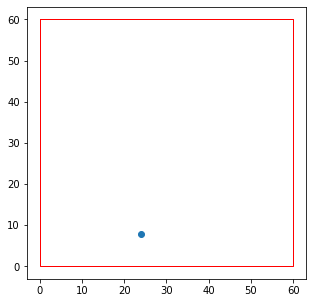

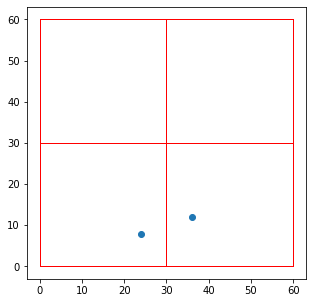

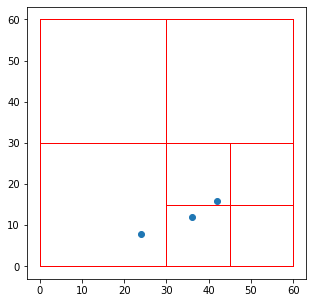

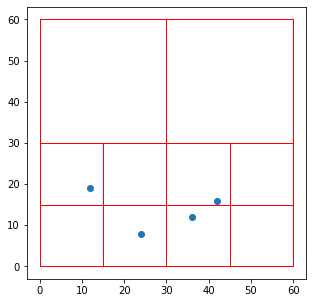

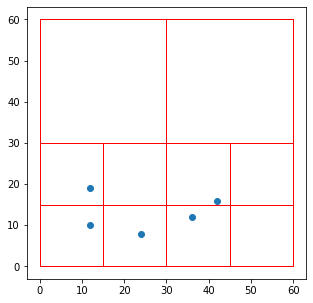

In [450]:
qt.clear()
x_list = []
y_list = []
for point in points:
    print(point)
    plt.figure(figsize=(5,5))
    x_list.append(point.x)
    y_list.append(point.y)
    qt.insert(point)
    plt.scatter(x_list,y_list)
    qt.show()
    plt.show()


## We can do all things at once:

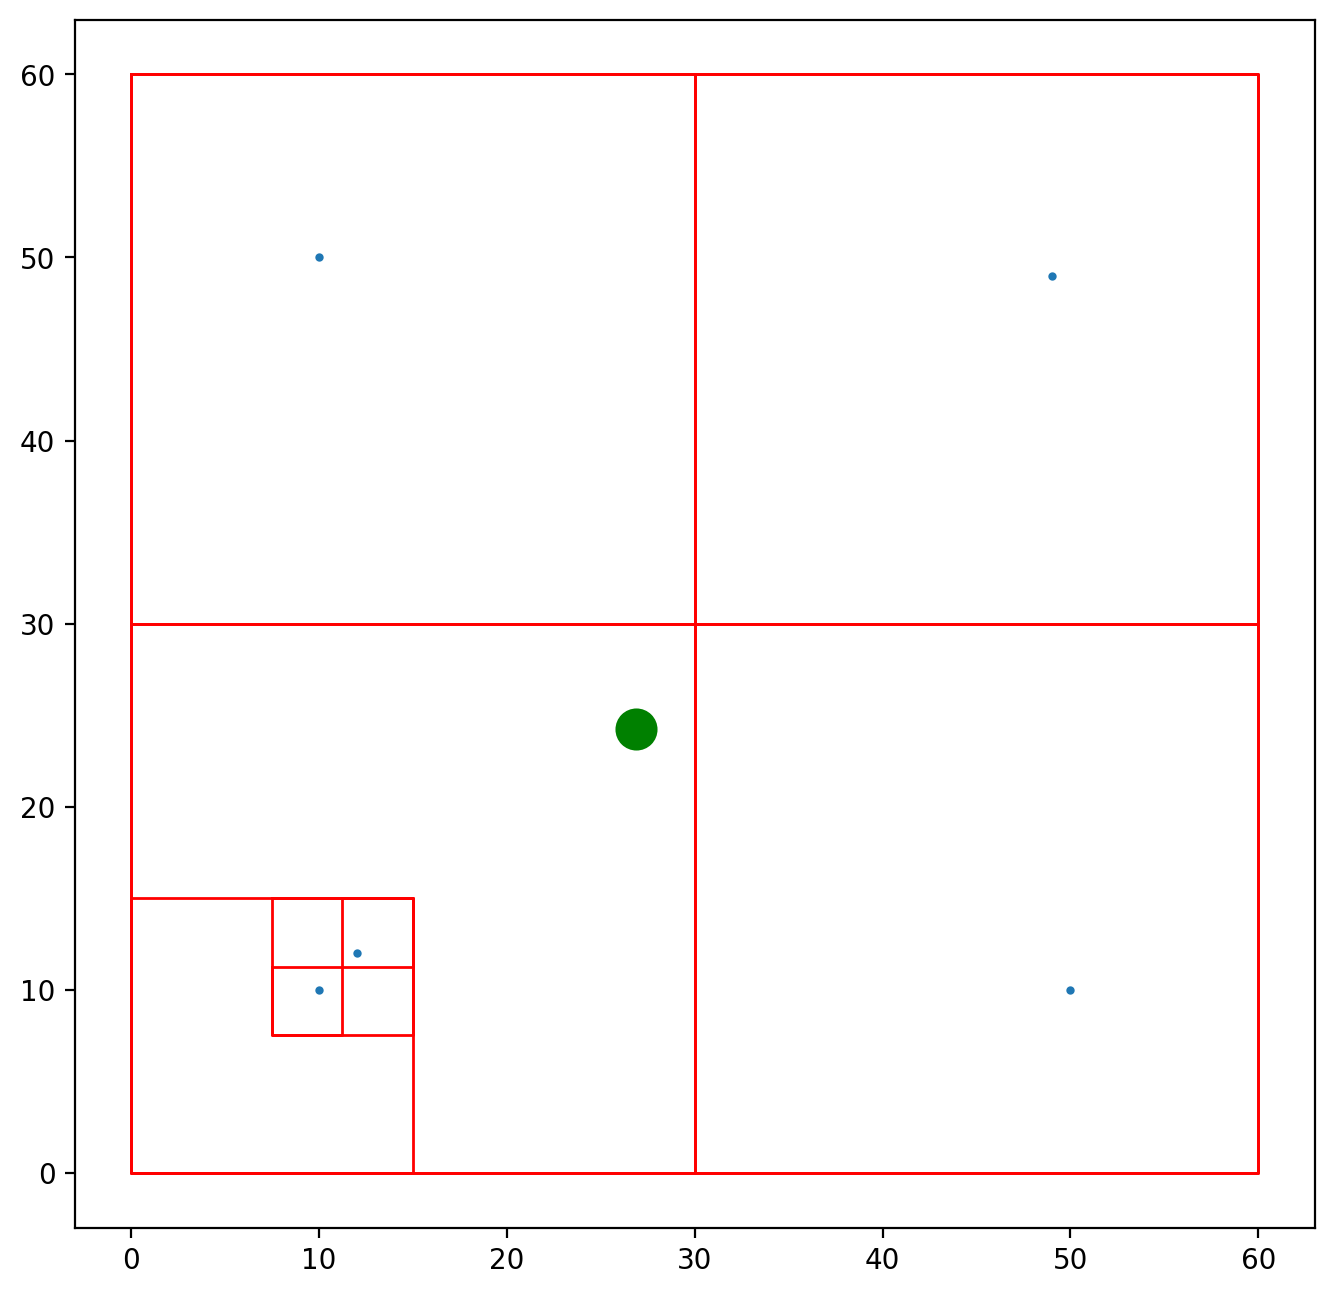

In [664]:
qt = Quadtree(Rectangle(30,30,60,60), G=1,theta_=0.5,n=1)

# points_random = [Point(x=np.random.uniform(0,60),
#                        y=np.random.uniform(0,60),
#                        identifier=np.random.randint(1,100),
#                       mass = np.random.uniform(1,100)) for i in range(10)]
p1 = Point(x=10,y=50, identifier=1, mass=10)
p2 = Point(x=49,y=49, identifier=2, mass=11)
p3 = Point(x=12,y=12, identifier=3, mass=12)
p4 = Point(x=10,y=10, identifier=4, mass=13)
p5 = Point(x=50,y=10, identifier=5, mass=14)

p_list = [p1,p2,p3,p4,p5]
qt.clear()
for p in p_list:
    qt.insert(p)
    
plt.figure(figsize=(8,8),dpi=200)
plt.scatter([p.x for p in p_list], [p.y for p in p_list],s=4)
# Center of mass for the entire quadrant:
plt.scatter(qt.center_of_mass_x/qt.mass, qt.center_of_mass_y/qt.mass, s=200, c='green')
qt.show(show_entire=True)
plt.show()

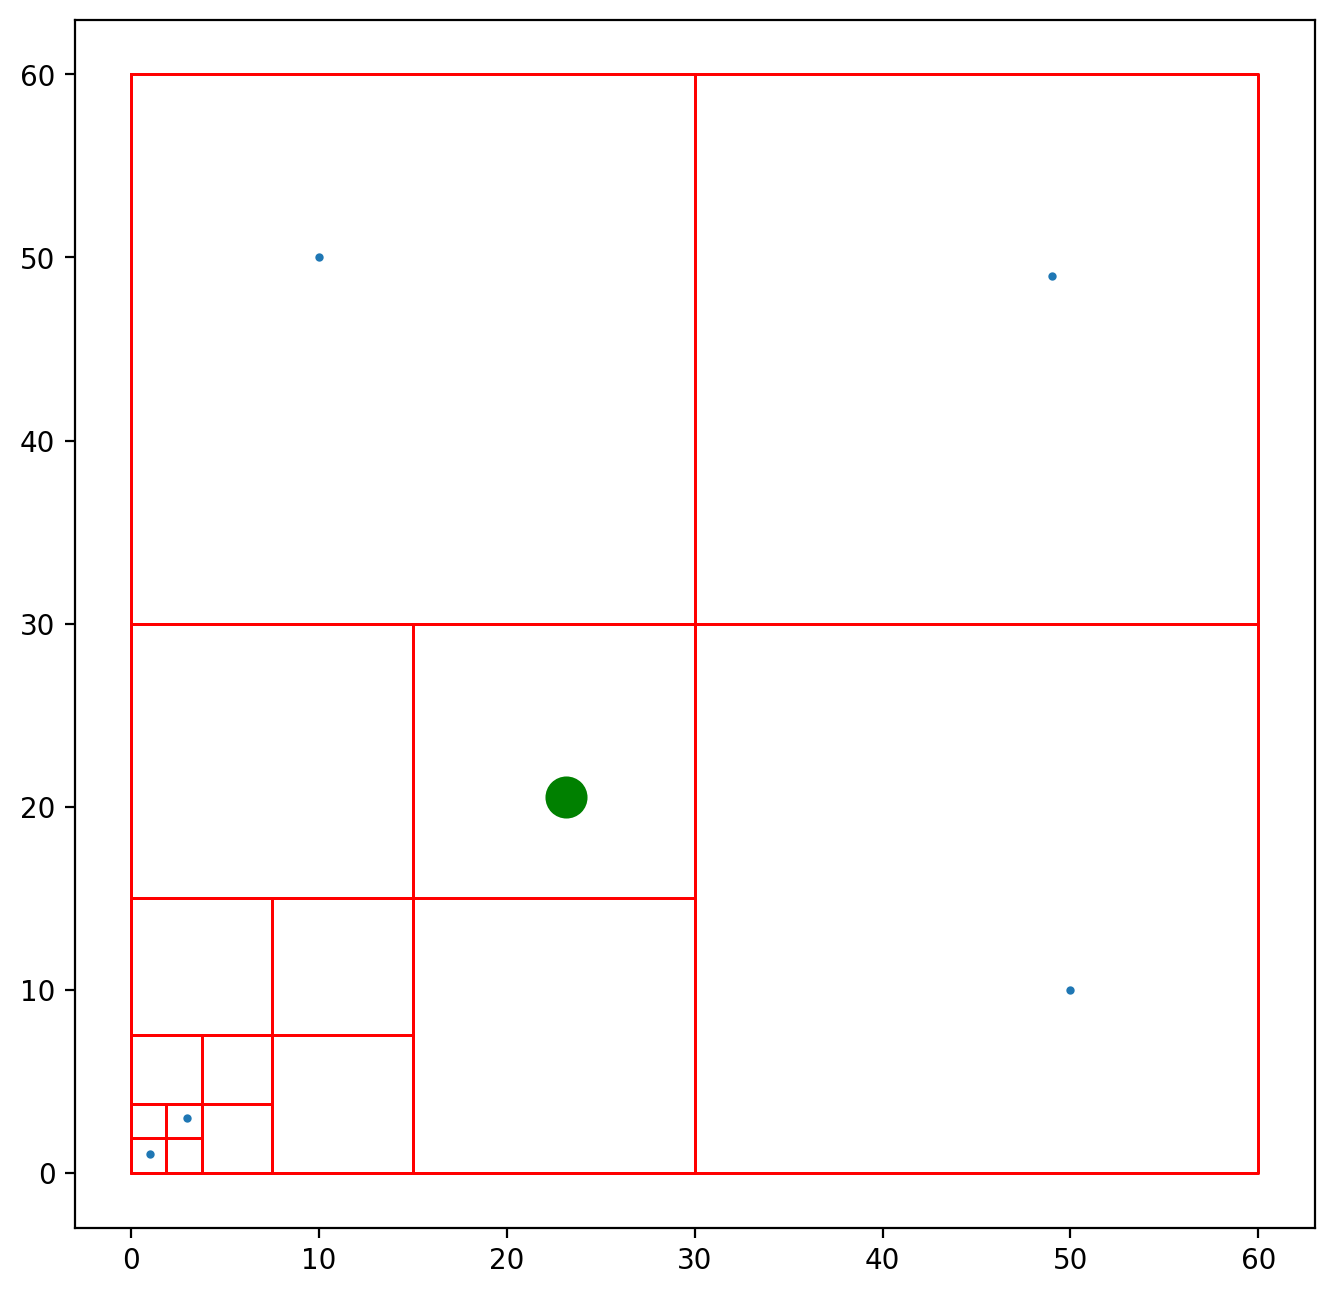

In [595]:
qt = Quadtree(Rectangle(30,30,60,60), G=1,theta_=0.4,n=1)

# points_random = [Point(x=np.random.uniform(0,60),
#                        y=np.random.uniform(0,60),
#                        identifier=np.random.randint(1,100),
#                       mass = np.random.uniform(1,100)) for i in range(10)]
p1 = Point(x=10,y=50, identifier=1, mass=10)
p2 = Point(x=49,y=49, identifier=2, mass=11)
p3 = Point(x=1,y=1, identifier=3, mass=12)
p4 = Point(x=3,y=3, identifier=4, mass=13)
p5 = Point(x=50,y=10, identifier=5, mass=14)

p_list = [p1,p2,p3,p4,p5]
qt.clear()
for p in p_list:
    qt.insert(p)

qt.calculate_force(p2)
plt.figure(figsize=(8,8),dpi=200)
plt.scatter([p.x for p in p_list], [p.y for p in p_list],s=4)
# plt.scatter(qt.quads[2].center_of_mass()[0],qt.quads[2].center_of_mass()[0])
# Center of mass for the entire quadrant:
plt.scatter(qt.center_of_mass_x/qt.mass, qt.center_of_mass_y/qt.mass, s=200, c='green')
qt.show()
plt.show()

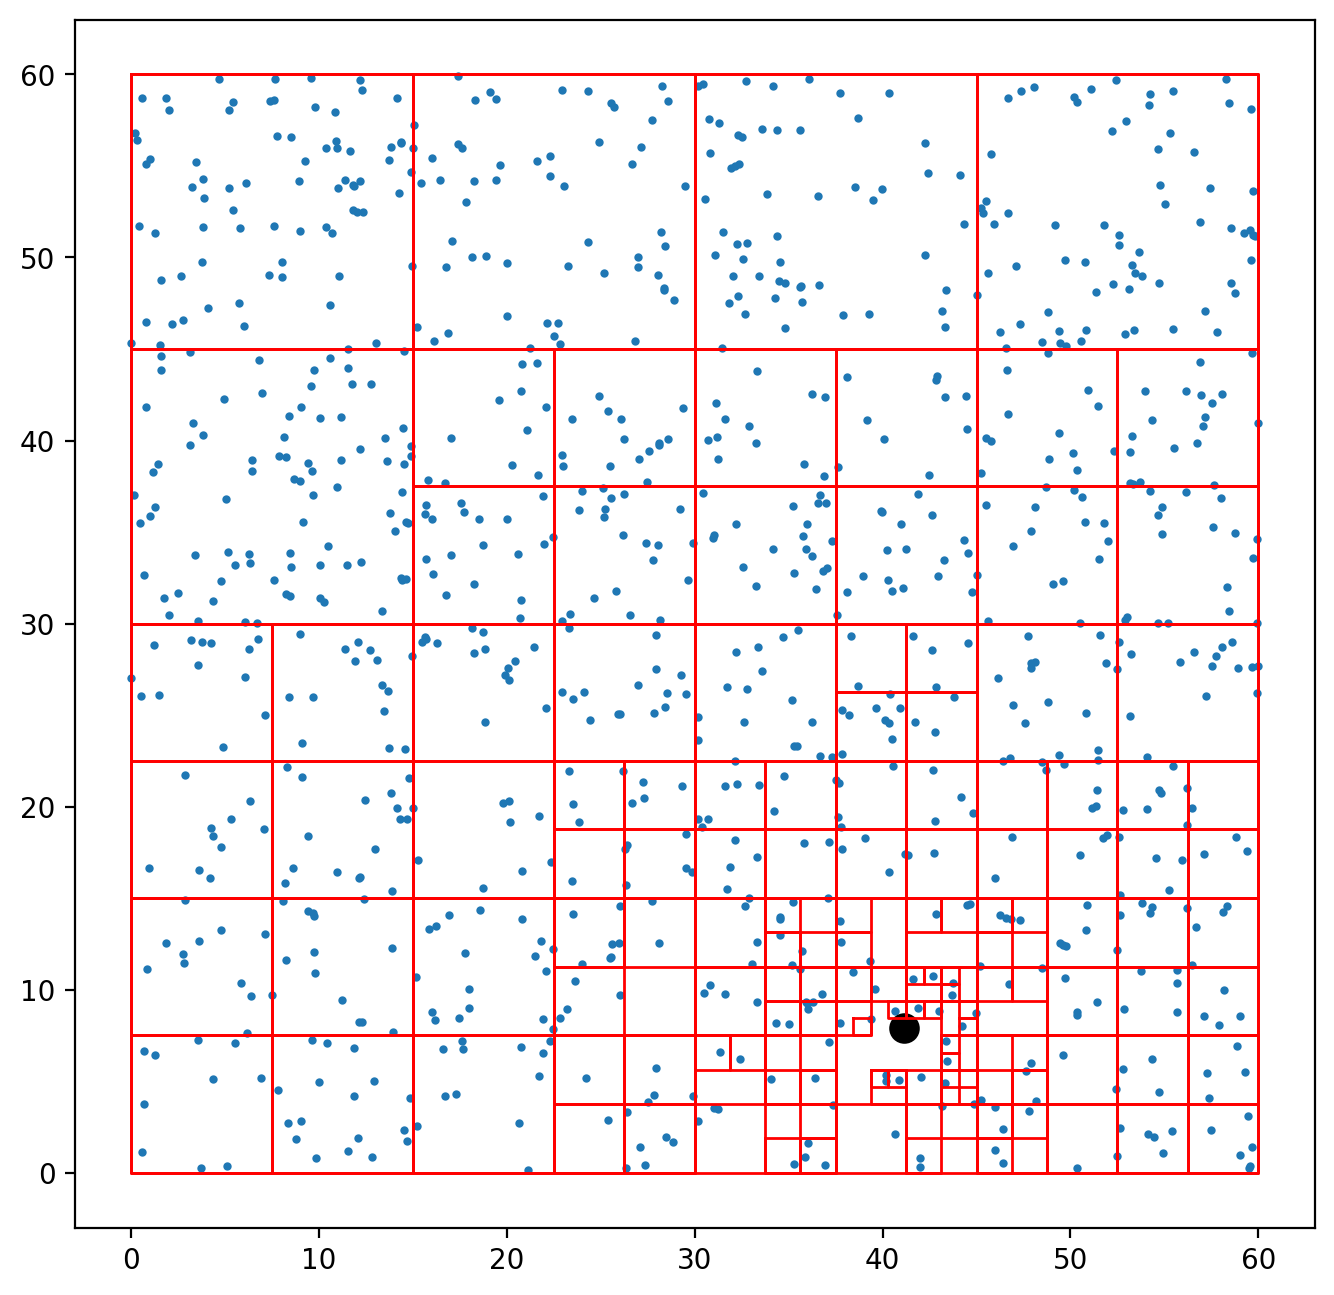

In [693]:
qt = Quadtree(Rectangle(30,30,60,60), G=1,theta_=0.4,n=1)

points_random = [Point(x=np.random.uniform(0,60),
                       y=np.random.uniform(0,60),
                       identifier=np.random.randint(1,100),
                      mass = np.random.uniform(1,100)) for i in range(1000)]


p_list = points_random
qt.clear()
for p in p_list:
    qt.insert(p)

plt.figure(figsize=(8,8),dpi=200)
plt.scatter([p.x for p in p_list], [p.y for p in p_list],s=4)
# plt.scatter(qt.quads[2].center_of_mass()[0],qt.quads[2].center_of_mass()[0])
# Center of mass for the entire quadrant:
#plt.scatter(qt.center_of_mass_x/qt.mass, qt.center_of_mass_y/qt.mass, s=200, c='green')
pov = points_random[14]
plt.scatter(pov.x,pov.y,color='black',s=100)
qt.show_from_point(pov)
# qt.show()
plt.show()

# Galaxy with stable orbit for stars

In [680]:
# Rectangle (boundary) specs
width = 500
height = 500
center_x = width/2
center_y = height/2
boundary = Rectangle(center_x-0.01,center_y-0.01,width,height)


# New points
points = []

black_hole_point = Point(center_x,center_y, identifier=1, mass= 500,vx=0,vy=0)
# black hole at center
points.append(black_hole_point)

# Assign stars to this galaxy with random mass:
for i in range(400):
    point = Point(x=np.random.normal(points[0].x,100) , y=np.random.normal(points[0].y, 100),
                        mass=np.random.uniform(98,100),
                        identifier=i+2)
    
    # Find the stable orbital velocity and update the
    #point.find_stable_orbital_velocity(black_hole_point,g_const=0.01)
    points.append(point)
    
barnes_hut_sim(points,show_quadtree=False,
               g_const=0.01,dt=0.09,theta=1,
               show_quadtree_wrt_point=points[100],add_quadtree_plot=False,
               n_frames=1500,save_to_video='barnes_hut_pov_display_not_bc.mp4')

KeyboardInterrupt: 

## Second Sample:

In [828]:
# specs of Rectangle (the main boundary):
width = 400
height = 400
center_x = width/2
center_y = height/2
boundary = Rectangle(center_x,center_y,width,height)

# New points
points = []

black_hole_point = Point(center_x-0.01,center_y-0.01, identifier=1, mass= 5000,vx=0,vy=0)
# black hole at center
points.append(black_hole_point)

# rogue: black hole:
rogue_x = center_x + width*0.25
rogue_y = center_y + height*0.25
rogue_vx = 0
rogue_vy = 0
points.append(Point(rogue_x,rogue_y,identifier= 2, mass=3500,vx=rogue_vx,vy=rogue_vy))

#stars for rogue black hole
for i in range(100):
    r = np.random.uniform(0,30)
    theta = i*360/50
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-10,0)
    thetav = np.random.normal(loc=-40,scale=1) if abs(x) <3 and abs(y) <3 else np.random.normal(-1,1)
    vx,vy = get_cart_coords_vel(0,0,r,theta)
    
    mass = np.random.randint(300,1000)
    points.append(Point(x+rogue_x,y+rogue_y, identifier=i+3,mass=mass,vx=vx+rogue_vx,vy=vy+rogue_vy))


# stars for center black hole
for i in range(100):
    r = np.random.uniform(1,70)
    theta = i*360/80
    x,y = get_cart_coords(r, theta)
    
    mass = np.random.randint(200,2000)
        points.append(Point(x+center_x,y+center_y,identifier=i+503, # 200 is the number of stars in rogue black hold
                        mass=mass,vx=,vy=vy))

    
##############
#####RUNNING THE SIMULATION #########################
# barnes_hut_sim(points,
#                dt=0.01,
#                g_const=0.1,
#                theta=0.5,
#                _wrap_points=False,
#                save_to_video='barnes_hut_1.mp4',
#                show_quadtree_wrt_point=points[0],n_frames=500)

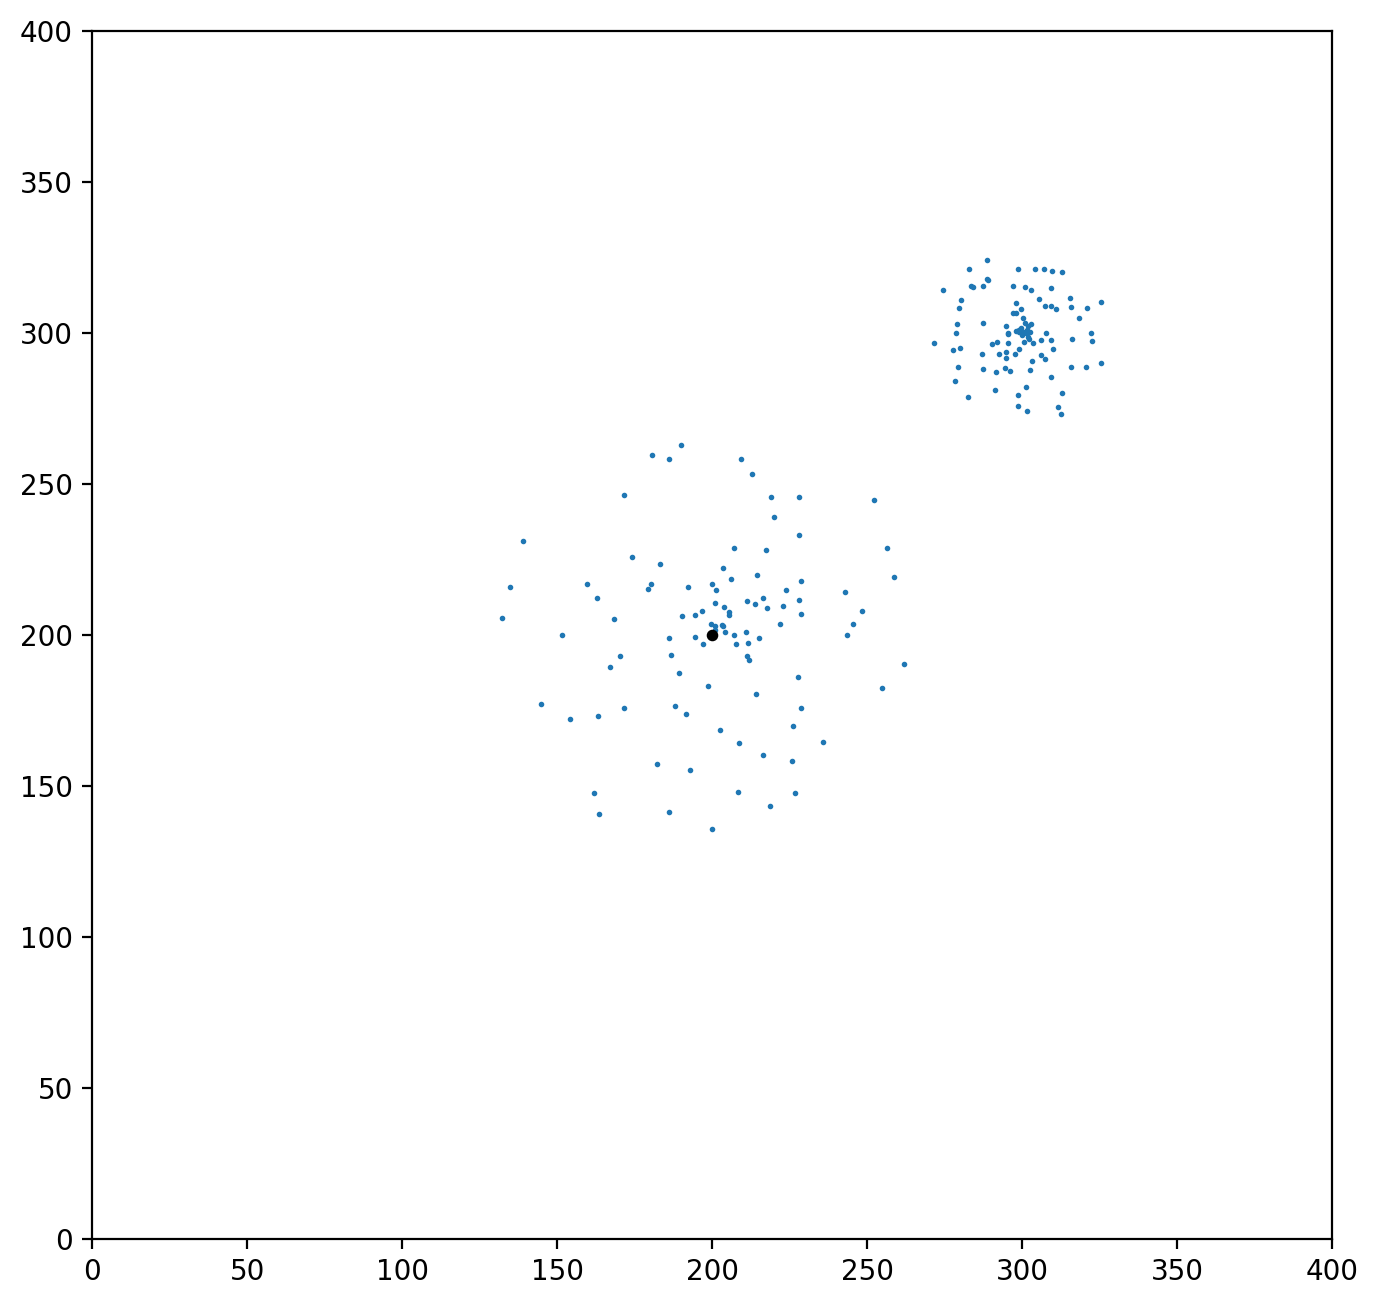

In [829]:
qt = Quadtree(boundary,G=1,theta_=0.5,n=1)
for p in points:
    qt.insert(p)

plt.figure(figsize=(8,8),dpi=200)
plt.scatter([p.x for p in points], [p.y for p in points],s=1)
# plt.scatter(qt.quads[2].center_of_mass()[0],qt.quads[2].center_of_mass()[0])
# Center of mass for the entire quadrant:
#plt.scatter(qt.center_of_mass_x/qt.mass, qt.center_of_mass_y/qt.mass, s=200, c='green')
pov = points[0]
plt.scatter(pov.x,pov.y,color='black',s=10)
# qt.show_from_point(pov,show_mass=True)
# qt.show(show_entire=False)
plt.xlim(qt.boundary.x - qt.boundary.w/2,qt.boundary.x+qt.boundary.w/2)
plt.ylim(qt.boundary.y-qt.boundary.h/2,qt.boundary.y+qt.boundary.h/2)
plt.show()

In [675]:
qt.boundary.x

200.0

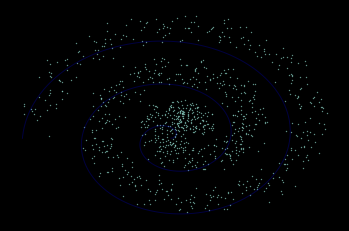

In [152]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')  
fig, ax = plt.subplots()

# Generate x and y coordinates for the spiral pattern
theta = np.linspace(0, 5 * np.pi, 1000)
r = np.linspace(0, 1, 1000)
x = r * np.cos(theta)
y = r * np.sin(theta)

x_init = []
y_init = []

for i in range(1000):
    x_init.append(x[i] + 0.25*np.random.rand())
    y_init.append(y[i] + 0.25*np.random.rand())

# Plot the spiral pattern
ax.plot(x,y,color='blue',linewidth=1,alpha=0.25)
ax.scatter(x_init, y_init, s=0.1)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.show()

In [ ]:
theta = np.linspace(0, 5 * np.pi, 1000)
r = np.linspace(0, 1, 1000)
x = r * np.cos(theta)
y = r * np.sin(theta)

x_init = []
y_init = []

for i in range(1000):
    x_init.append(x[i] + 0.25*np.random.rand())
    y_init.append(y[i] + 0.25*np.random.rand())

<ipython-input-62-f7ca8dd2858f>:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


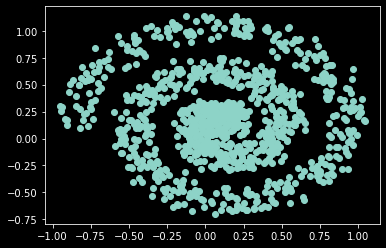

In [62]:
fig, ax = plt.subplots()
ax.scatter(x_init, y_init)

# Convert the figure to a numpy array
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [65]:
data.shape

(288, 432, 3)

In [709]:
def plummer_density_profile(n, r_scale):
    """
    Returns x and y coordinates, and x and y velocities of n stars using the Plummer density profile

    Parameters:
    n (int): Number of stars to generate
    r_scale (float): Scale radius of the Plummer density profile

    Returns:
    x, y, vx, vy (np.ndarray): x and y coordinates, and x and y velocities of the stars
    """
    r = np.random.uniform(0, r_scale, n)
    theta = np.random.uniform(0, 2 * np.pi, n)
    x = r * np.cos(theta) / (1 + (r/r_scale)**2)**0.5
    y = r * np.sin(theta) / (1 + (r/r_scale)**2)**0.5
    v_r = -1 * (r_scale**2 + r**2)**(-0.5) * r / (r_scale**2 + r**2)**0.5
    v_theta = (r_scale**2 + r**2)**(-0.5)
    vx = v_r * np.cos(theta) - v_theta * np.sin(theta)
    vy = v_r * np.sin(theta) + v_theta * np.cos(theta)
    return x, y, vx, vy

In [744]:

def plummer_density_profile_with_mass(n, r_scale, mass,G, center=(0, 0)):
    """
    Returns x and y coordinates, and x and y velocities of n stars using the Plummer density profile with mass

    Parameters:
    n (int): Number of stars to generate
    r_scale (float): Scale radius of the Plummer density profile
    mass (float): Mass of the central object
    center (tuple): (x, y) position of the center of the Plummer sphere

    Returns:
    x, y, vx, vy (np.ndarray): x and y coordinates, and x and y velocities of the stars
    """
    r = np.random.uniform(0, r_scale, n)
    theta = np.random.uniform(0, 2 * np.pi, n)
    x = center[0] + r * np.cos(theta) / (1 + (r/r_scale)**2)**0.5
    y = center[1] + r * np.sin(theta) / (1 + (r/r_scale)**2)**0.5
    v_circ = (G * mass / r)**0.5
    vx = v_circ * np.sin(theta)
    vy = -1 * v_circ * np.cos(theta)
    return x, y, vx, vy

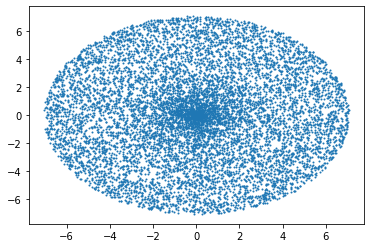

In [710]:
x,y,vx,vy= plummer_density_profile(10000,10)

plt.scatter(x,y,s=1)

# Using the `Plummer_density_profile` to sort out a galaxy

### Some parameters:
mass = solar mass

distance = light year (average diameter of galaxy = 105,700 ly)

Gravitaitonal Constant = G = $\dfrac{ly^3}{solar mass \times millionyears^2}$

In [784]:
from astropy import constants

In [786]:
import astropy

In [797]:
astropy.units.M_sun

Unit("solMass")

In [794]:
np.square((1000000*astropy.units.yr).decompose())

<Quantity 9.95882118e+26 s2>

In [801]:
constants.G.to_value((astropy.units.lyr.decompose())**3/((astropy.units.M_sun.decompose())*(np.square((1000000*astropy.units.yr).decompose()))))

0.1560793896760612

In [810]:
G = constants.G.to_value((astropy.units.lyr)**3/((astropy.units.M_sun)*(np.square((1000000*astropy.units.yr)))))

In [809]:
G

4.2798190963515605e-10

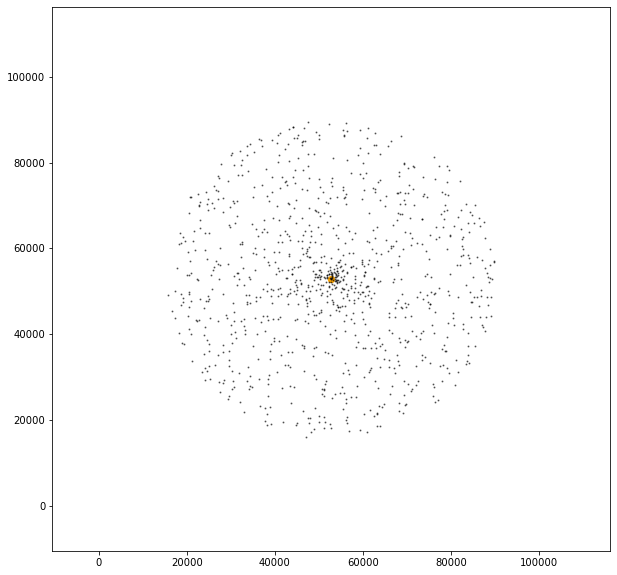

frame: 86/1000


In [ ]:
# Rectangle (boundary) specs
width = 105700
height = 105700
center_x = width/2
center_y = height/2
boundary = Rectangle(center_x-0.01,center_y-0.01,width,height)


# New points
points = []
black_hole_point = Point(center_x,center_y, mass= 4.15e6,vx=0,vy=0)
# black hole at center
points.append(black_hole_point)

x,y,vx,vy = plummer_density_profile_with_mass(n=1000,
                                              r_scale=(width-width*0.5),
                                              mass=black_hole_point.mass,
                                              G=G,
                                              center=(center_x,center_y))


for i in range(len(x)):
    points.append(Point(x[i], y[i],
                        mass = np.random.uniform(0.4,1.8),
                        vx = vx[i], vy = vy[i]))


barnes_hut_sim(points,
               g_const=G,dt=1,theta=1,
               n_frames=1000,save_to_video="plummer_8_30fps_final_rip_pc.mp4")

In [ ]:
def get_escap():
    